In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import squidpy as sq
import anndata as ad
import seaborn as sns
import networkx as nx
import pandas as pd

import sys
sys.path.append("../src/")
sys.path.append("/data/bionets/je30bery/truncated_graphs/src/")
from truncated_graphs import *

- create random spatial data
- connect nearest neighbors
- compute centrality scores
- for variable r, truncate graph by border r and compute centralities for everything inside, taking only nodes insight the new "window" into account
- calculate error of new and old centralities
- scatter

In [26]:
n = 20**2
bounds = (0, 20)
borders = [1, 2, 3, 4, 5, 6, 7, 8]
type = "regular"
coordinates = generate_coordinates(n=n, bounds=bounds, type=type)
reg_original = create_anndata(coordinates, n_neighs=4, bounds=bounds)
reg_original, reg_truncated = fully_process(adata_original=reg_original, bounds=bounds, borders=borders)

type = "hexagonal"
coordinates = generate_coordinates(n=n, bounds=bounds, type=type)
hex_original = create_anndata(coordinates, n_neighs=6, bounds=bounds)
hex_original, hex_truncated = fully_process(adata_original=hex_original, bounds=bounds, borders=borders)

type = "normal"
coordinates = generate_coordinates(n=2000, bounds=bounds, type=type)
normal_original = create_anndata(coordinates, n_neighs=6, bounds=bounds)
normal_original, normal_truncated = fully_process(adata_original=normal_original, bounds=bounds, borders=borders)

/data/bionets/je30bery/conda/envs/ppi/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/data/bionets/je30bery/conda/envs/ppi/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/data/bionets/je30bery/conda/envs/ppi/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/data/bionets/je30bery/conda/envs/ppi/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/data/bionets/je30bery/conda/envs/ppi/li

In [33]:
pearson = list()
kendall = list()
cosine = list()
measures = ["degree", "closeness", "betweenness", "harmonic"]
statistics = ["pearson correlation", "kendall's tau", "cosine distance"]
results = dict()

for i, adatas_truncated in enumerate([reg_truncated, hex_truncated, normal_truncated]):
    results[i] = dict()
    for measure in measures:
        results[i][measure] = pd.DataFrame(index=borders)
        for statistic in statistics:
            vals = list()
            for border in borders:
                vals.append(adatas_truncated[border].uns[f"{measure} {statistic}"])
            results[i][measure][statistic.capitalize()] = vals    

In [34]:
for i in results.keys():
    conc = pd.concat(results[i])
    conc.reset_index(inplace=True)
    conc.rename({"level_0": "Centrality measure", "level_1": "Border width"}, inplace=True, axis=1)
    results[i] = conc
conc = pd.concat(results)
conc.reset_index(inplace=True)

In [36]:
conc.rename({"level_0": "Type"}, inplace=True, axis=1)
conc["Type"].replace({0: "Regular", 1: "Hexagonal", 2: "Normal"}, inplace=True)
conc.drop(["level_1"], axis=1)

/tmp/ipykernel_3822223/2753380138.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  conc["Type"].replace({0: "Regular", 1: "Hexagonal", 2: "Normal"}, inplace=True)


,Type,Centrality measure,Border width,Pearson correlation,Kendall's tau,Cosine distance
0,Regular,degree,1,NaN,NaN,0.006849
1,Regular,degree,2,NaN,NaN,0.007688
2,Regular,degree,3,NaN,NaN,0.008759
3,Regular,degree,4,NaN,NaN,0.010173
4,Regular,degree,5,NaN,NaN,0.012122
...,...,...,...,...,...,...
91,Normal,harmonic,4,0.820557,0.786397,0.024546
92,Normal,harmonic,5,0.791566,0.660876,0.025435
93,Normal,harmonic,6,0.766997,0.520997,0.024416
94,Normal,harmonic,7,0.595626,0.531998,0.022770


In [39]:
melted = pd.melt(conc, id_vars=["Type", "Centrality measure", "Border width", "level_1"], value_name="Value", var_name="Statistic")

/data/bionets/je30bery/conda/envs/ppi/lib/python3.9/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/data/bionets/je30bery/conda/envs/ppi/lib/python3.9/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/data/bionets/je30bery/conda/envs/ppi/lib/python3.9/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/dat

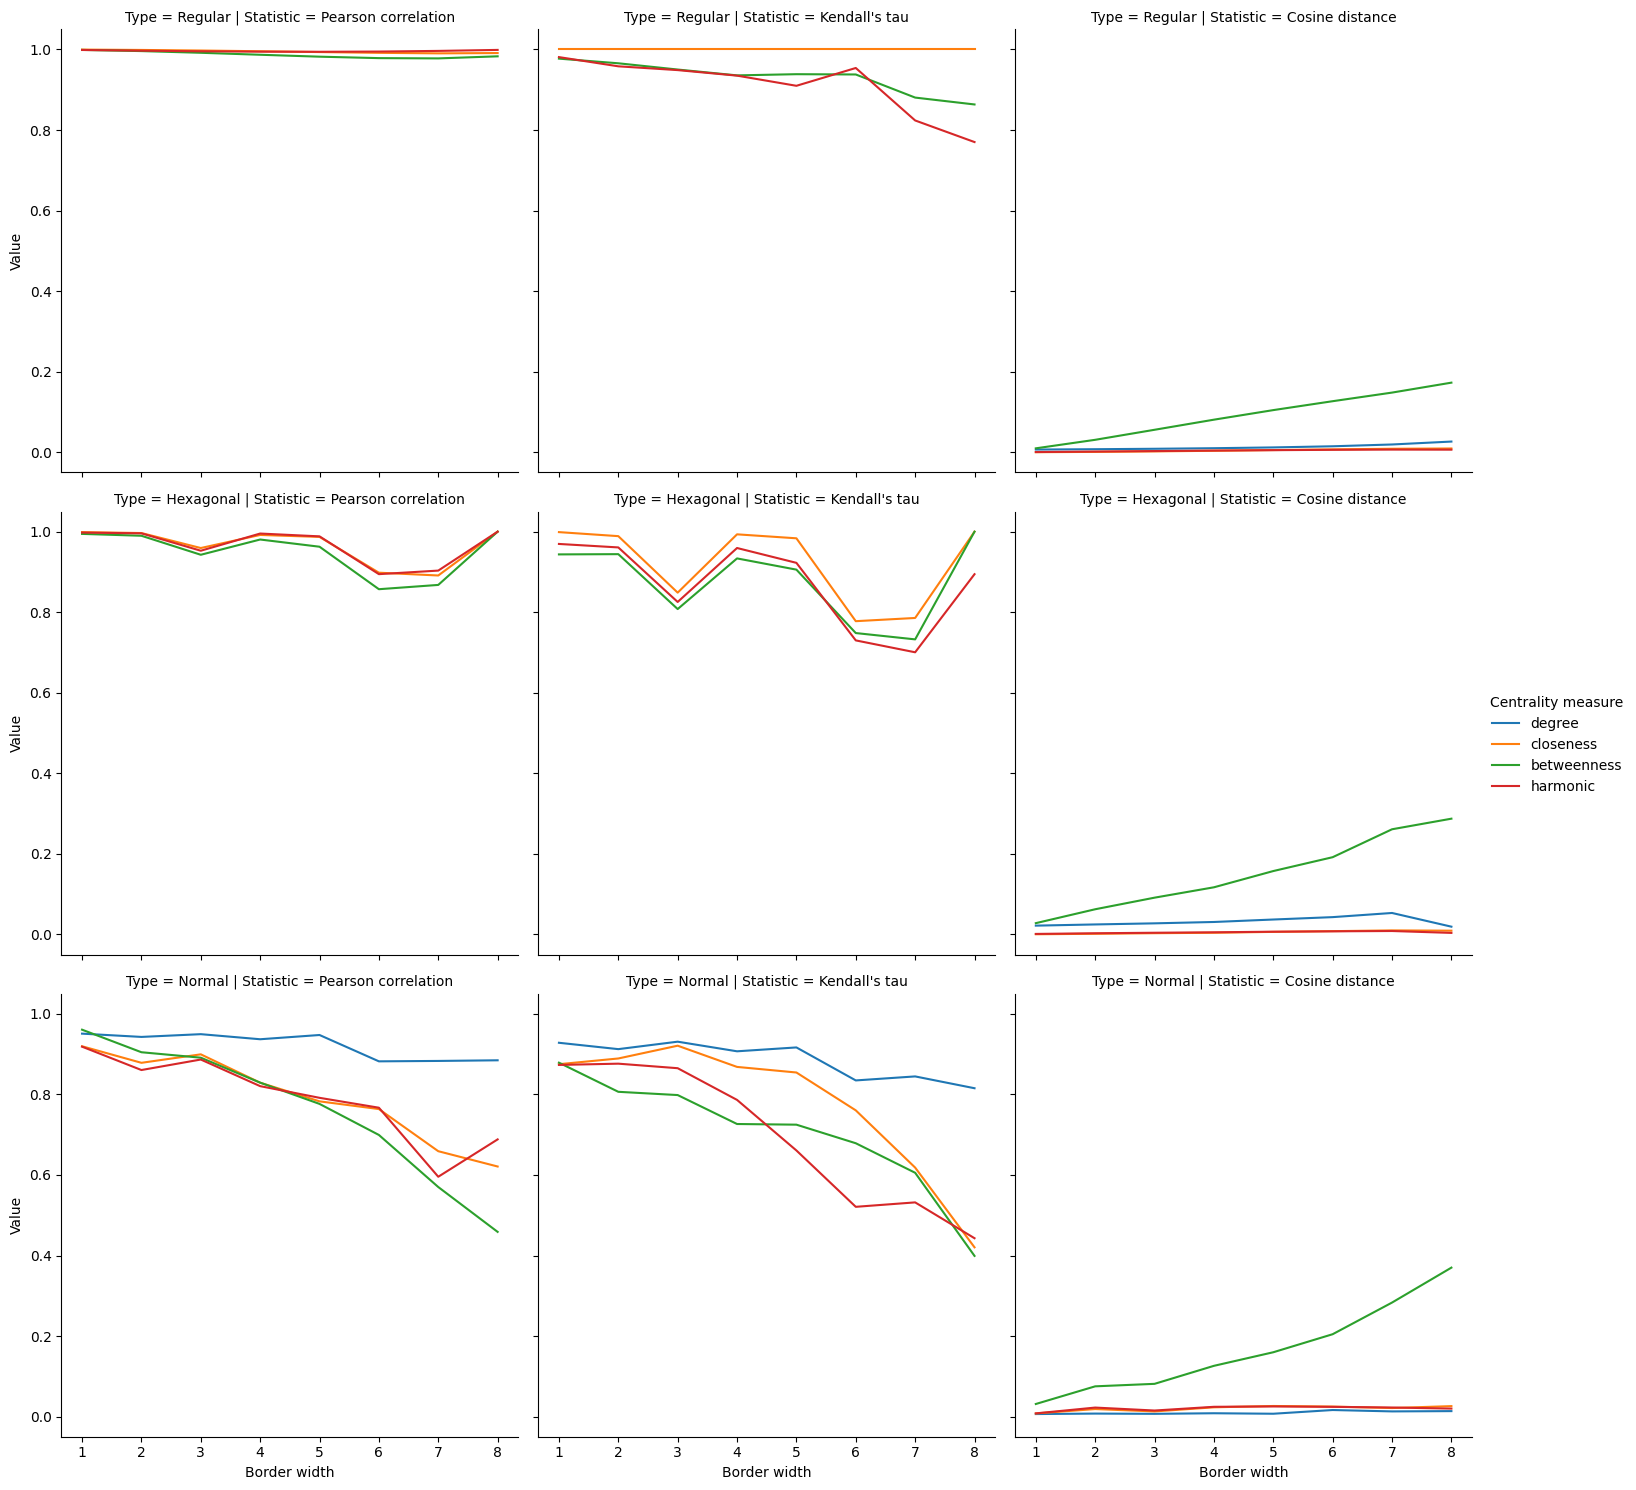

In [40]:
sns.relplot(melted, kind="line", y="Value", x="Border width", hue="Centrality measure", col="Statistic", row="Type")

In [ ]:
measure = "betweenness"

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
pal = sns.color_palette("plasma", len(adata_original))

for i, border in enumerate(adatas_truncated.keys()):
    ax.scatter(adatas_truncated[border].obs["distance_to_border"], [border] * len(adatas_truncated[border]), adatas_truncated[border].obs[f"{measure} error"], 
           color=np.array(pal)[adatas_truncated[border].obs_names.values.astype(int)], marker='o', alpha=0.5)

ax.set_xlabel('Distance to Closest Border')
ax.set_ylabel('Border Width')
ax.set_zlabel('Error')
ax.set_title(f'{measure.capitalize()} Measure Errors vs Distance to Border and Border Width')
ax.set_box_aspect(None, zoom=0.85)
plt.tight_layout()
plt.savefig(f"../result_plots/{type}/{measure}_by_border_on_{type}_grid_n={n}.png", bbox_inches="tight")

In [13]:
hex_original[1]

View of AnnData object with n_obs × n_vars = 1 × 1
    obs: 'distance_to_border'
    uns: 'spatial_neighbors'
    obsm: 'spatial'
    obsp: 'spatial_connectivities', 'spatial_distances'

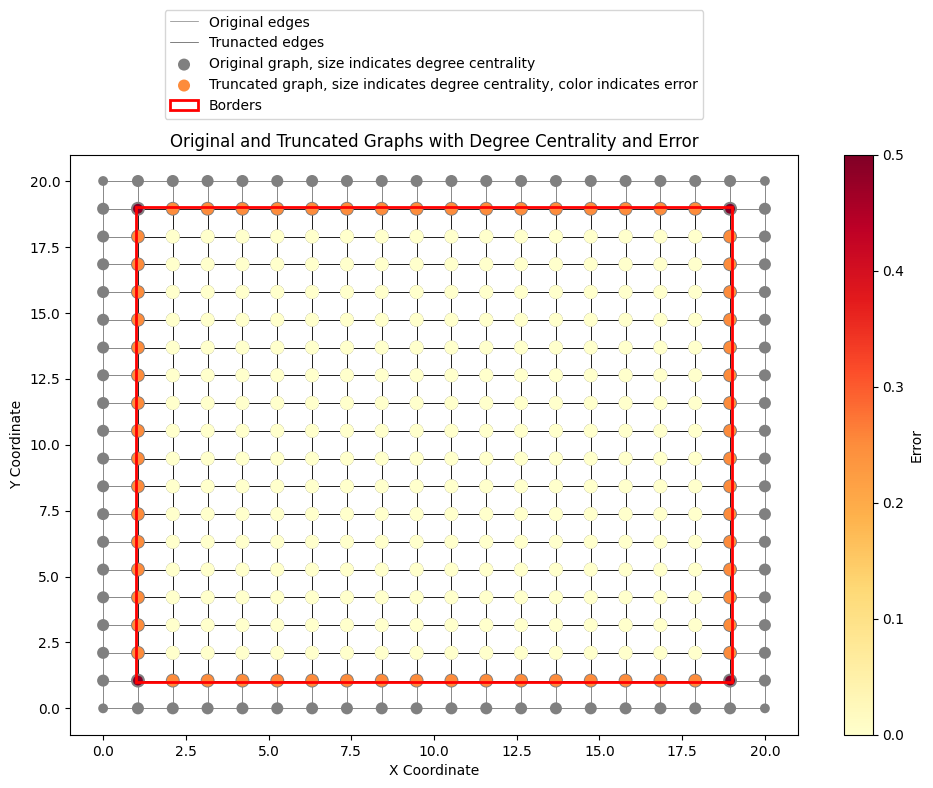

In [24]:
border = 1
plot_graphs_with_errors(reg_original, reg_truncated[border], border=border, measure=measure, bounds=bounds)
#plt.savefig(f"../result_plots/{type}/{type}_{measure}_border={border}_n={n}.png")

In [ ]:
adata_original.obs[measure][adatas_truncated[1].obs_names]